<a href="https://colab.research.google.com/github/kirath2205/Final-Year-Project/blob/main/Resnet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np


def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

In [2]:
!pip install Keras-applications

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [3]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
import tensorflow.keras as keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, UpSampling2D, Flatten, BatchNormalization, Dense, Dropout, GlobalAveragePooling2D , UpSampling3D
from tensorflow.keras import optimizers
from keras.datasets import cifar100,cifar10,fashion_mnist
import tensorflow as tf
from keras.utils import np_utils
import numpy as np
import matplotlib.pyplot as plt
import time
from skimage.transform import resize
from keras import applications
from tensorflow.keras.applications.resnet50 import ResNet50 , preprocess_input , decode_predictions
from keras.preprocessing.image import ImageDataGenerator

In [4]:
def select_dataset(index=1): #1 for cifar10 , 2 for cifar100 , 3 for fashion mnist
  if(index == 1):
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    channel = 3
    num_classes = 10
  if(index == 2):
    (x_train, y_train), (x_test, y_test) = cifar100.load_data()
    num_classes = 100
    channel = 3
  if(index == 3):
    (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
    x_train = x_train.reshape((60000, 28, 28, 1))
    x_test =  x_test.reshape((10000, 28, 28, 1))
    num_classes = 10
    y_train = np_utils.to_categorical(y_train, num_classes)
    y_test = np_utils.to_categorical(y_test, num_classes)
    channel = 1
    return (x_train , y_train , x_test , y_test , num_classes , channel)

  #Pre-process the data
  x_train = preprocess_input(x_train)
  x_test = preprocess_input(x_test)

  datagen = ImageDataGenerator(preprocessing_function=get_random_eraser(v_l=0, v_h=1, pixel_level=True))
  datagen.fit(x_train)
  y_train = np_utils.to_categorical(y_train, num_classes)
  y_test = np_utils.to_categorical(y_test, num_classes)

  return (x_train , y_train , x_test , y_test , num_classes , channel , datagen)

In [5]:
def Resnet50(num_classes , channel=3):
  if(channel == 3):
    resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
  else:
    resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(112, 112, 3))

  for layer in resnet_model.layers:
    if isinstance(layer, BatchNormalization):
      layer.trainable = True
    else:
      layer.trainable = False
  model = Sequential()
  if(channel==1):
    model.add(UpSampling3D((4,4,3)))
  else:
    model.add(UpSampling2D((7,7)))
  model.add(resnet_model)
  model.add(GlobalAveragePooling2D())
  model.add(Dense(256, activation='relu'))
  model.add(Dropout(.25))
  model.add(BatchNormalization())
  model.add(Dense(num_classes, activation='softmax'))
  model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
  return model

In [10]:
index = 1
x_train , y_train , x_test , y_test , num_classes ,channel , datagen = select_dataset(index)
model = Resnet50(num_classes,channel)
model_name = 'desktop/Trained_models/resnet50_cifar10'
model_path = 'desktop/Trained_models/resnet50_cifar10.h5'

In [6]:
index = 2
x_train , y_train , x_test , y_test , num_classes ,channel , datagen = select_dataset(index)
model = Resnet50(num_classes,channel)
model_name = 'desktop/Trained_models/resnet50_cifar100'
model_path = 'desktop/Trained_models/resnet50_cifar100.h5'

In [ ]:
index = 3
x_train , y_train , x_test , y_test , num_classes ,channel  = select_dataset(index)
model = Resnet50(num_classes,channel)
model_name = 'resnet50_mnist'
model_path = '/content/resnet_mnist.h5'

In [11]:
batch_size = 128 # 256 for mnist , 128 for cifar-10 , 64 for cifar-100
callbacks = [ 
    tf.keras.callbacks.ModelCheckpoint(model_name, monitor='val_accuracy', verbose=1, save_best_only=True),
    tf.keras.callbacks.ReduceLROnPlateau( factor = 0.5, patience = 5, min_lr = 0.000001, verbose = 1 ),
    tf.keras.callbacks.EarlyStopping(monitor = 'val_loss' , patience = 10)
  ]
if(channel == 3):
  history = model.fit_generator(datagen.flow(x_train, y_train,
                                  batch_size=batch_size),
                                  steps_per_epoch=x_train.shape[0] // batch_size,
                                  epochs=100,
                                  validation_data=(x_test, y_test),
                                  callbacks = callbacks)

  model.save(model_path)
else:
  history = model.fit(x_train , y_train , batch_size=batch_size ,steps_per_epoch=x_train.shape[0] // batch_size, epochs=50, validation_data=(x_test, y_test),callbacks=callbacks)
  model.save(model_path)

Epoch 1/100
390/390 [==============================] - ETA: 0s - loss: 0.6209 - accuracy: 0.7862
Epoch 00001: val_accuracy improved from -inf to 0.90540, saving model to desktop/Trained_models/resnet50_cifar10
INFO:tensorflow:Assets written to: desktop/Trained_models/resnet50_cifar10/assets
390/390 [==============================] - 184s 472ms/step - loss: 0.6209 - accuracy: 0.7862 - val_loss: 0.2818 - val_accuracy: 0.9054 - lr: 0.0010
Epoch 2/100
390/390 [==============================] - ETA: 0s - loss: 0.3425 - accuracy: 0.8814
Epoch 00002: val_accuracy improved from 0.90540 to 0.92350, saving model to desktop/Trained_models/resnet50_cifar10
INFO:tensorflow:Assets written to: desktop/Trained_models/resnet50_cifar10/assets
390/390 [==============================] - 184s 472ms/step - loss: 0.3425 - accuracy: 0.8814 - val_loss: 0.2259 - val_accuracy: 0.9235 - lr: 0.0010
Epoch 3/100
390/390 [==============================] - ETA: 0s - loss: 0.2714 - accuracy: 0.9056
Epoch 00003: val_acc

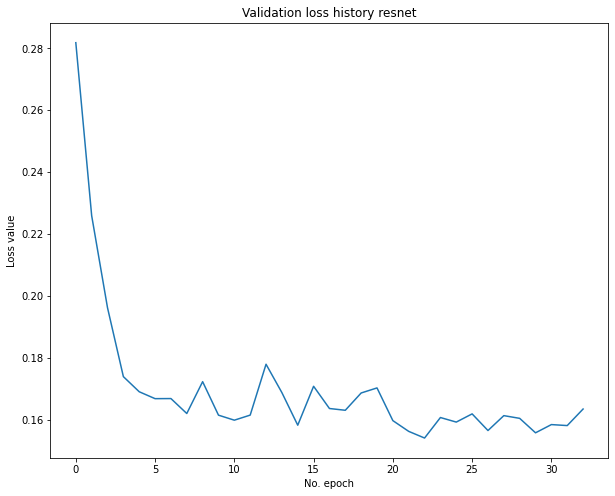

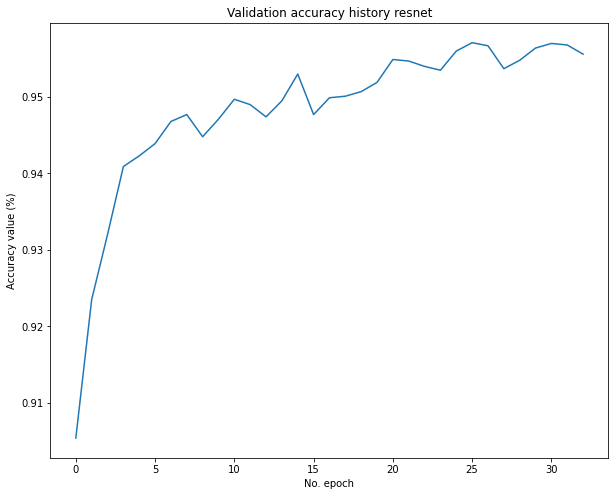

In [12]:
import matplotlib.pyplot as plt



# Visualize history
# Plot history: Loss
plt.figure(figsize = (10,8))
plt.plot(history.history['val_loss'])
plt.title('Validation loss history resnet')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.show()

# Plot history: Accuracy
plt.figure(figsize = (10,8))
plt.plot(history.history['val_accuracy'])
plt.title('Validation accuracy history resnet')
plt.ylabel('Accuracy value (%)')
plt.xlabel('No. epoch')
plt.show()